In [3]:
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.interpolate as spi
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py
import pathlib as pl
#from pynufft import NUFFT
mpl.rcParams['figure.dpi']= 720
import os
my_path = os.path.abspath(r'C:\Users\TU-IEP-Schultze\Documents\Experiment\femto_ion_spectra')

#font = {
#        'size'   : 35}
#mpl.rc('font', **font)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"],
#     'font.size': 22})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
#     'font.size': 22
# })

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from calculate_k_b import Calibration_mass

cal = Calibration_mass()
class FFT_ionS():

    def __init__(self, delay, data, massRange=[5,50], dcRange = 2, label =None):

        self.peakRange = [-80,80]  # range of the peak
        self.delay = delay*2*3.33564*10**-15
        self.ifpadding = 1
        self.longstage = True
        #self.paddedDelay
        self.data = np.array(data)
        self.massRange = massRange
        self.dcRange = dcRange
        self.windowSize = 100
        self.calculator = Calibration_mass()
        self.label = label
        self.gasBottle = {
            "CH3OH+":self.calculator.cal_pixel(32) +self.peakRange,
            "CH2OH+":self.calculator.cal_pixel(31) +self.peakRange,
            "CHOH+":self.calculator.cal_pixel(30) +self.peakRange,
            "CHO+":self.calculator.cal_pixel(29) +self.peakRange,
            #"CO+":self.calculator.cal_pixel(28) +self.peakRange,
            #"CH2+":self.calculator.cal_pixel(14) +self.peakRange,
            #"N": self.calculator.cal_pixel(14) +self.peakRange,
            #"O": self.calculator.cal_pixel(16)+self.peakRange,
            #"H2O": self.calculator.cal_pixel(18)+self.peakRange,
            #"N2": self.calculator.cal_pixel(28)+self.peakRange,
            #"$O_2$": self.calculator.cal_pixel(32)+self.peakRange,
            #"N": self.calculator.cal_pixel(14) +self.peakRange,
            #"O": self.calculator.cal_pixel(16)+self.peakRange,
            "H2O": self.calculator.cal_pixel(18)+self.peakRange,
            #"N2": self.calculator.cal_pixel(28)+self.peakRange,
            #"O2": self.calculator.cal_pixel(32)+self.peakRange,
            #"Ar": self.calculator.cal_pixel(32)+self.peakRange,
            #"air": [0,8000],
            }
        self.spectraBottle = {}
        self.fftS = {}
        self.stftS = {}

    def FFT(self, t, y):
        n = len(t)
        delta = (max(t) - min(t)) / (n-1)
        k = int(n/2)
        f = np.arange(k) / (n*delta) / 10**12  # frequency unit THz
        Y = abs(sp.fft.fft(y))[:k]
        return np.array([f, Y])

    def mass_spectra(self):

        for gas in self.gasBottle.keys():
            [pixelMin, pixelMax] = self.gasBottle[gas]
            pixelMin = round(pixelMin)
            pixelMax = round(pixelMax)
            #print(np.size(self.data,0))
            #print(pixelMin)
            self.spectraBottle[gas] = np.sum(self.data[pixelMin:pixelMax, :], 0)

    def window(self, windowSize = 0, direction = 'left', shift = 0, rmDC = True):
        for gas in self.spectraBottle.keys():

            data = self.spectraBottle[gas]
            __len = np.size(data)
            if rmDC:
                a = np.array([[data[0], 1], [data[__len-1], 1]])
                #print(data[0],data[__len-1])
                b = np.array([1, __len])
                [k, b] = np.linalg.solve(a, b)
                dcShift = np.arange(0, __len)*k+b
                data = data-dcShift
            if direction == 'left':
                # window = np.concatenate((
                #     np.mean(data[windowSize])*(np.zeros(windowSize)+1), data[-(__len-windowSize):]
                #     ))
                window = data[-(__len-windowSize):]
                self.delay = self.delay[-(__len-windowSize):]
            elif direction == 'right':
                # window = np.concatenate((
                #     data[:__len-windowSize],data[__len-windowSize-1]*(np.zeros(windowSize)+1)
                #     ))
                window = data[:__len-windowSize]
                self.delay = self.delay[:__len-windowSize]
            elif direction == 'middle':
                window = np.concatenate((
                    data[:round((__len-windowSize)/2)],#need to check again
                    (data[round((__len-windowSize)/2)]+data[round((__len+windowSize)/2)])/2*(np.zeros(windowSize)+1),
                    data[-(__len-round((__len+windowSize)/2)+1):]
                ))
            #self.paddedDelay = np.arange(self.delay[0])
        #if (stepNum_left%2) == 0:
        #    paddingWindow = np.concatenate(( np.zeros(int(stepNum_left/2))+1, 
        #    np.zeros(windowSize*2),np.zeros(int(stepNum_left/2))+1,np.zeros(paddingSize)))
        #    #self.paddedDelay = np.arange(self.delay[0])
        #else:
        #    paddingWindow = np.concatenate((np.zeros(paddingSize), np.zeros(int((stepNum_left-1)/2))+1, 
        #    np.zeros(windowSize*2),np.zeros(int((stepNum_left+1)/2))+1, np.zeros(paddingSize)))
            #plt.plot(dcShift)
            self.spectraBottle[gas] = window
            #print(np.shape(window))

    def padding(self, paddingSize = 0):
        delayStep = self.delay[2]-self.delay[1]
        self.delay = np.concatenate((
            np.arange(self.delay[0]-(paddingSize+1)*delayStep,self.delay[0],delayStep),
            self.delay,
            np.arange(self.delay[-1]+delayStep,self.delay[-1]+(paddingSize)*delayStep,delayStep)
            ))
        for gas in self.spectraBottle.keys():
            data = self.spectraBottle[gas]
            self.spectraBottle[gas] = np.concatenate(((np.zeros(paddingSize)), data, (np.zeros(paddingSize))),axis=0)
            #print(np.size(self.spectraBottle[gas],0))

    def interpS(self, interNum = 1):
        interpDelay = np.arange(self.delay[0], self.delay[-1], (self.delay[1]-self.delay[0])/(interNum+1))
        for gas in self.spectraBottle.keys():
            iS = np.interp(interpDelay, self.delay, self.spectraBottle[gas])
            self.spectraBottle[gas] = iS
            #print(np.shape(iS))
        self.delay = interpDelay
        #print(np.sie(self.delay))

    def FFTS(self):
        for gas in self.spectraBottle.keys():
            if self.spectraBottle[gas].size == self.spectraBottle[gas].shape[0]:
                if self.ifpadding:
                    self.fftS[gas] = self.FFT(
                        self.delay[self.windowSize::], self.spectraBottle[gas][self.windowSize::])
            else:
                self.fftS[gas] = np.zeros(self.spectraBottle[gas].shape[0]-self.windowSize)
                for i in range(self.spectraBottle[gas].shape[1]):
                    if self.ifpadding:
                        self.fftS[gas] += self.FFT(
                            self.delay[self.windowSize::], self.spectraBottle[gas][self.windowSize::,i])
    
    #def filterS(self, band):
     #   for gas in self.spectraBottle.keys():
      #      N, wn = sps.buttord(1e11, )
       #     fil = sps.butter(10, band, btype='band', fs=1000, output='sos')
        #    self.spectraBottle[gas] = sps.sosfilt(fil, self.spectraBottle[gas])

    def STFTS(self):
        for gas in self.spectraBottle.keys():
            f, t, self.stftS[gas] = sps.stft(self.spectraBottle[gas], fs=1/(self.delay[2]-self.delay[1]), nperseg = 80, nfft = 100)
            plt.pcolormesh(-t*10**15+333, f[3:]/10**12, np.abs(self.stftS[gas][3:,::]), cmap='jet', shading='gouraud')
            plt.xlim([-2000,50])
            plt.ylabel('Frequency [THz]')
            plt.xlabel('Time [fs]')
            plt.show()

    def rmvExp(self):
        for gas in self.spectraBottle.keys():
            self.spectraBottle[gas] = sps.detrend(self.spectraBottle[gas])
            #print(self.spectraBottle[gas][0],self.spectraBottle[gas][-1])
            #y = self.spectraBottle[gas]
            #k, b = np.polyfit(f.delay, np.log(y), 1)#, w=np.sqrt(y))
            #self.spectraBottle[gas] = y- np.exp(b)*np.exp(f.delay*k)
    
    def runingAverage(self, n = 5):
        runAve = lambda x, N: np.convolve(x, np.ones(N)/N, mode='valid')
        for gas in self.spectraBottle.keys():
            self.spectraBottle[gas] = runAve(self.spectraBottle[gas], n)

    def show_FFT(self):
        plt.figure()
        for gas in self.fftS.keys(): 
            [f,Y] = self.fftS[gas]
            plt.plot(f[self.dcRange:], Y[self.dcRange:]/np.sum(Y[self.dcRange:])*10000, label=gas)
            plt.xlabel('Frequency/THz')
            plt.ylabel('a.u.')
            plt.legend(gas)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('FFT.png', dpi=1200)

        #plt.figure()
        #for gas in ['N', 'O']:
        #    [f, Y] = self.fftS[gas]
        #    plt.plot(f[self.dcRange:], Y[self.dcRange:], label=gas)
        #    plt.xlabel('THz')
        #    plt.ylabel('a.b.')
        #    plt.legend(gas)
        #plt.legend()
        #plt.show()
    
    def show_Spectra(self, shift=0):
        plt.figure()
        for gas in self.spectraBottle.keys(): 
            #plt.plot(self.delay*10**15+shift, self.spectraBottle[gas], label=gas)
            plt.plot(self.spectraBottle[gas]/np.sum(self.spectraBottle[gas])/10000, label=gas)
            plt.xlabel("Delay/fs")
            plt.ylabel('a.u.')
            plt.legend(gas)
        plt.legend()
       # plt.tight_layout()
       # plt.savefig('Spectra.png', dpi=1200)
        plt.show()
    
    def dataProcess(self):
        #self.mass_spectra()
        self.FFTS()

class FFT_ionS2(FFT_ionS):
    def __init__(self, delay, data, massRange, dcRange=2, label=None, marker="s"):
        super().__init__(delay, data, massRange, dcRange, label)
        self.gasBottle = {"mass":self.calculator.cal_pixel(massRange)}
        self.dcRange = dcRange
        self.marker = marker     

    def FFTS(self):
        for gas in self.spectraBottle.keys():
            if self.ifpadding:
                #print(np.size(self.padding()))
                self.spectraBottle[gas] *= self.padding()
            [f, Y] = self.FFT(self.delay, self.spectraBottle[gas])
            self.fftS[gas] = [f[self.dcRange:], Y[self.dcRange:]]

    def show_FFT(self):
        plt.figure()
        for gas in self.fftS.keys(): 
            [f,Y] = self.fftS[gas]
            plt.plot(f[self.dcRange:], Y[self.dcRange:], label= self.label, marker = self.marker)
            plt.xlabel('THz')
            plt.ylabel('a.u.')
            plt.xlim
            plt.legend(gas)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(my_path + '\FFT.png', dpi=600)
    def show_Spectra(self, shift = 0):
        plt.figure()
        plt.plot(self.delay*10**15+shift, self.spectraBottle["mass"], label = self.label, marker = self.marker)
        plt.xlabel("Delay/fs")
        plt.legend()
        plt.tight_layout()
        #plt.savefig('FFT.png', dpi=600)
        plt.show()

class FFTOSC(FFT_ionS):
    def __init__(self, delay, data, massRange=[31,32], dcRange=2, label= None):
        super().__init__(delay, data, massRange=massRange, dcRange=dcRange, label=label)
    
    def mass_spectra(self):
        self.spectraBottle['"CH3OH+"'] = self.data

class compareFFT(FFT_ionS):
    def __init__(self, delay, data1, data2):
        super().__init__(delay, data)


-2912.2574724676706 909.3384480774439
48199


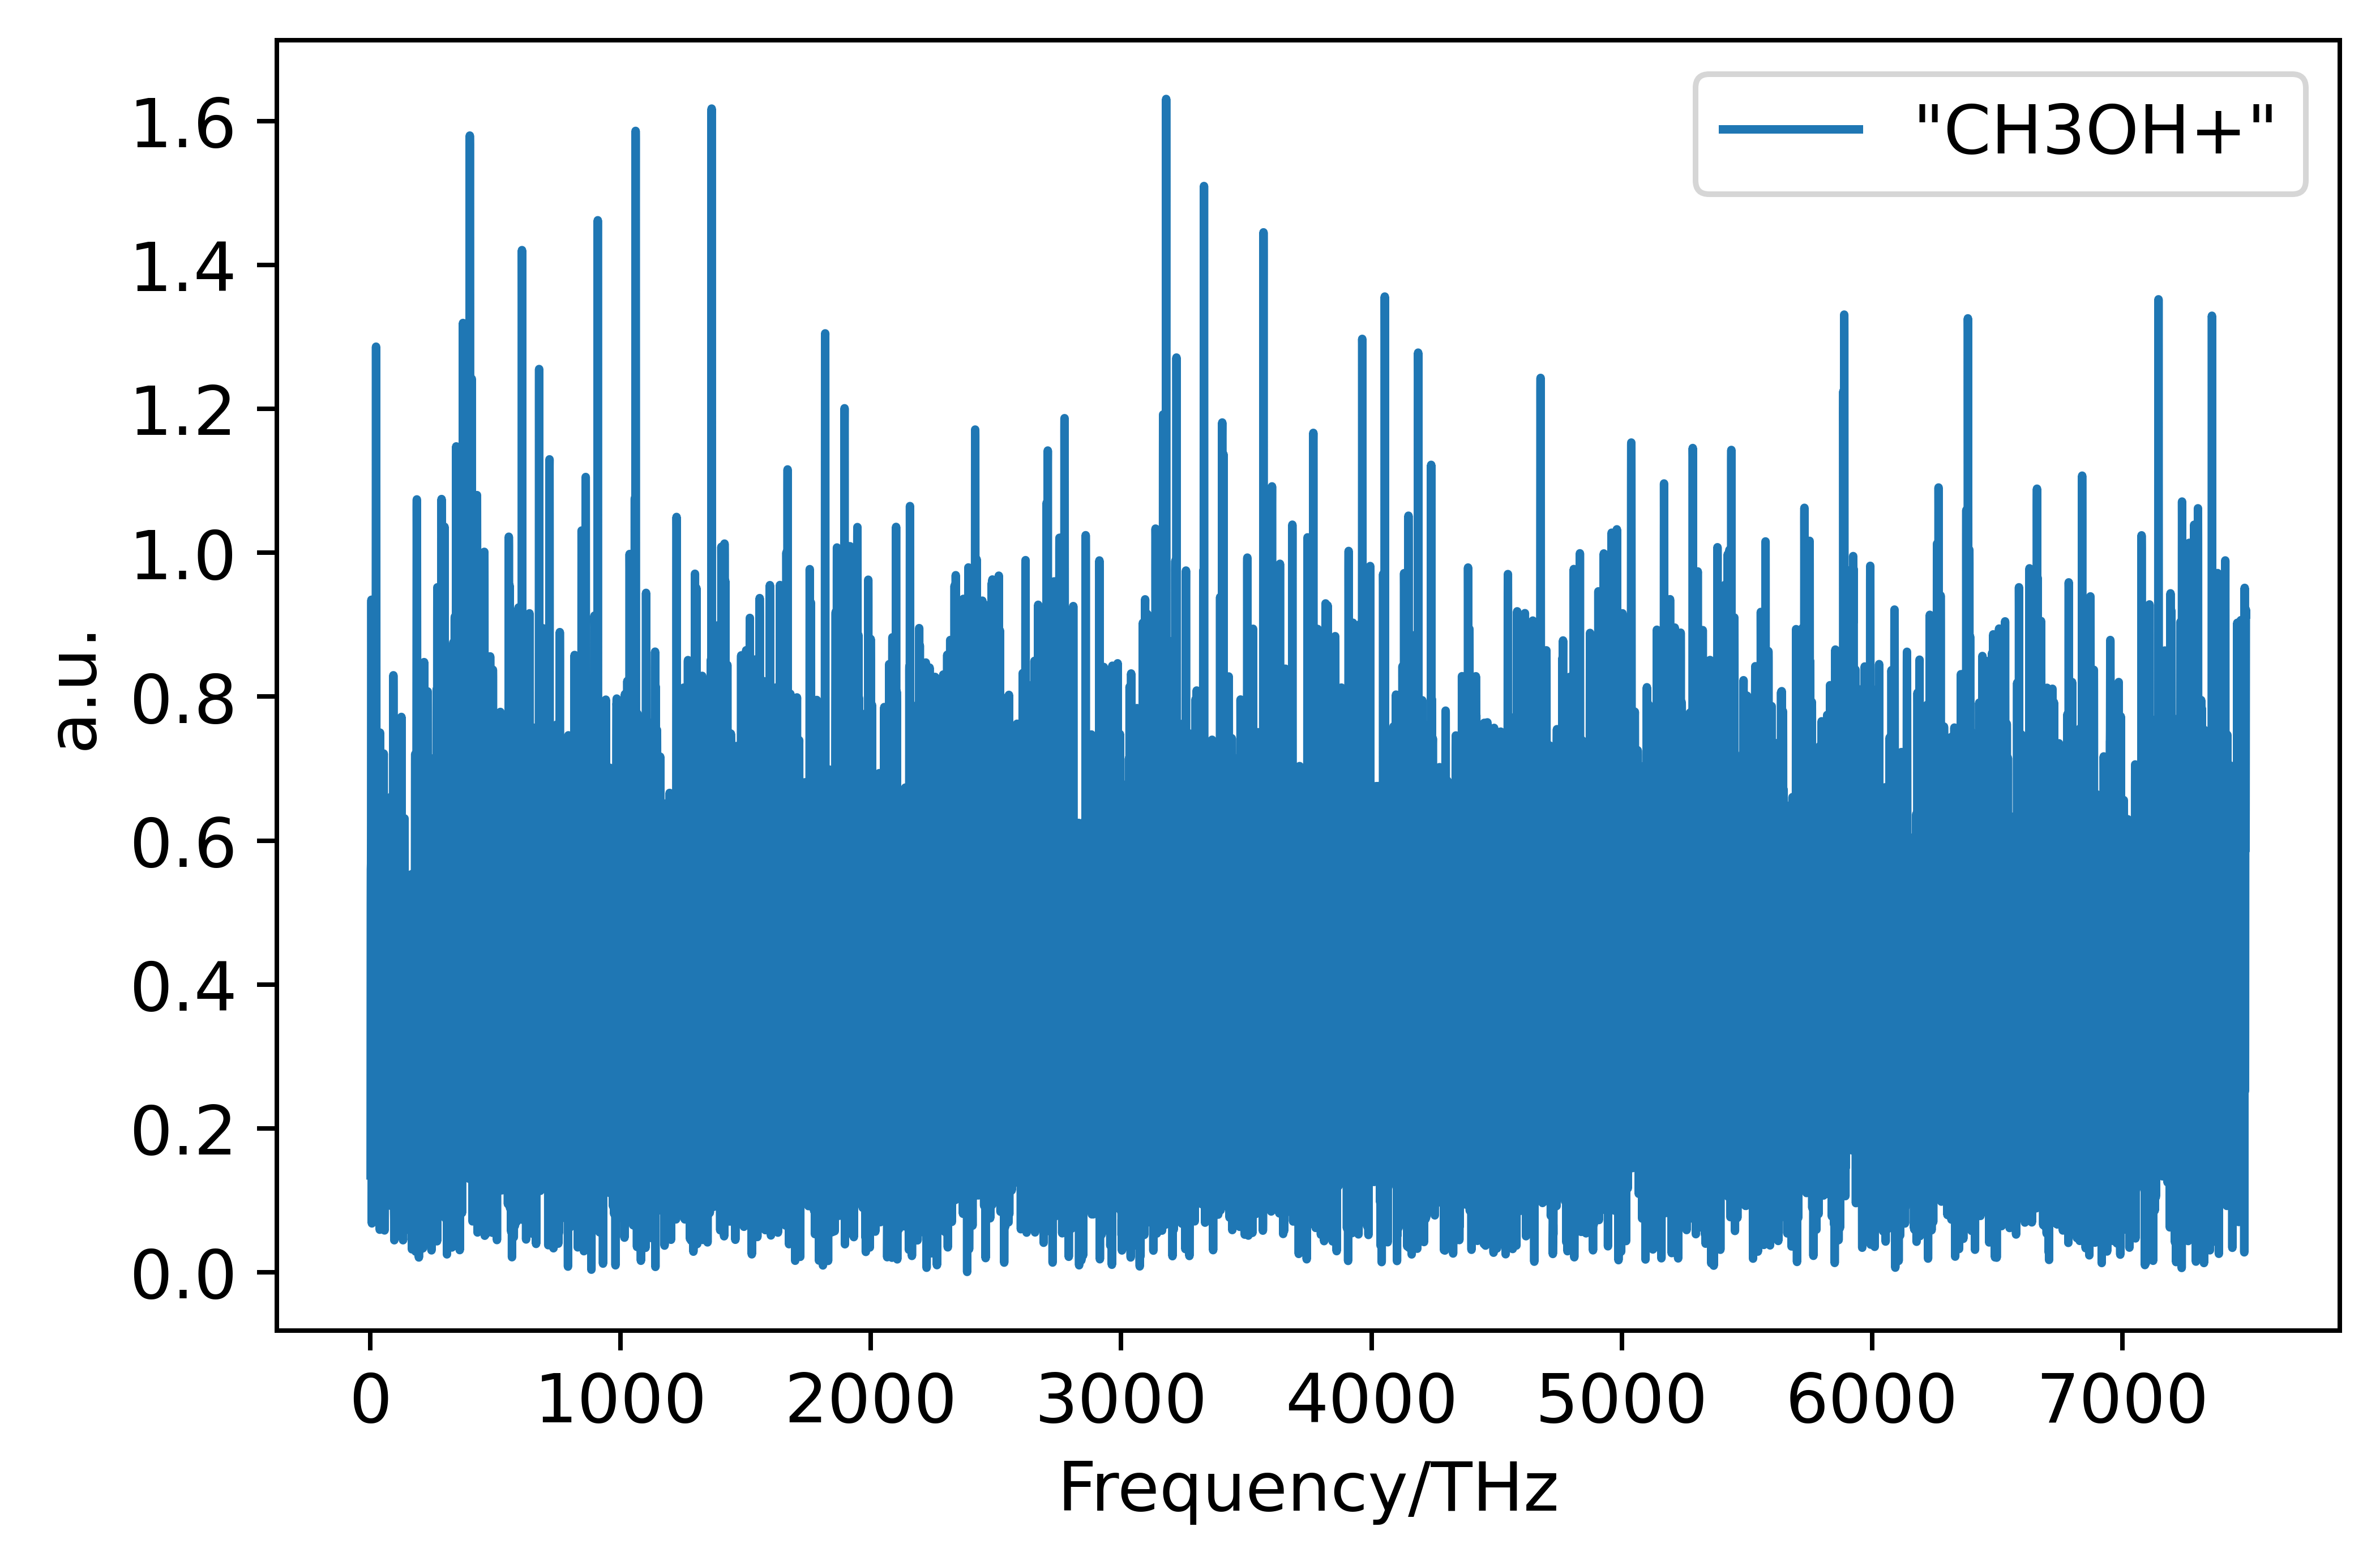

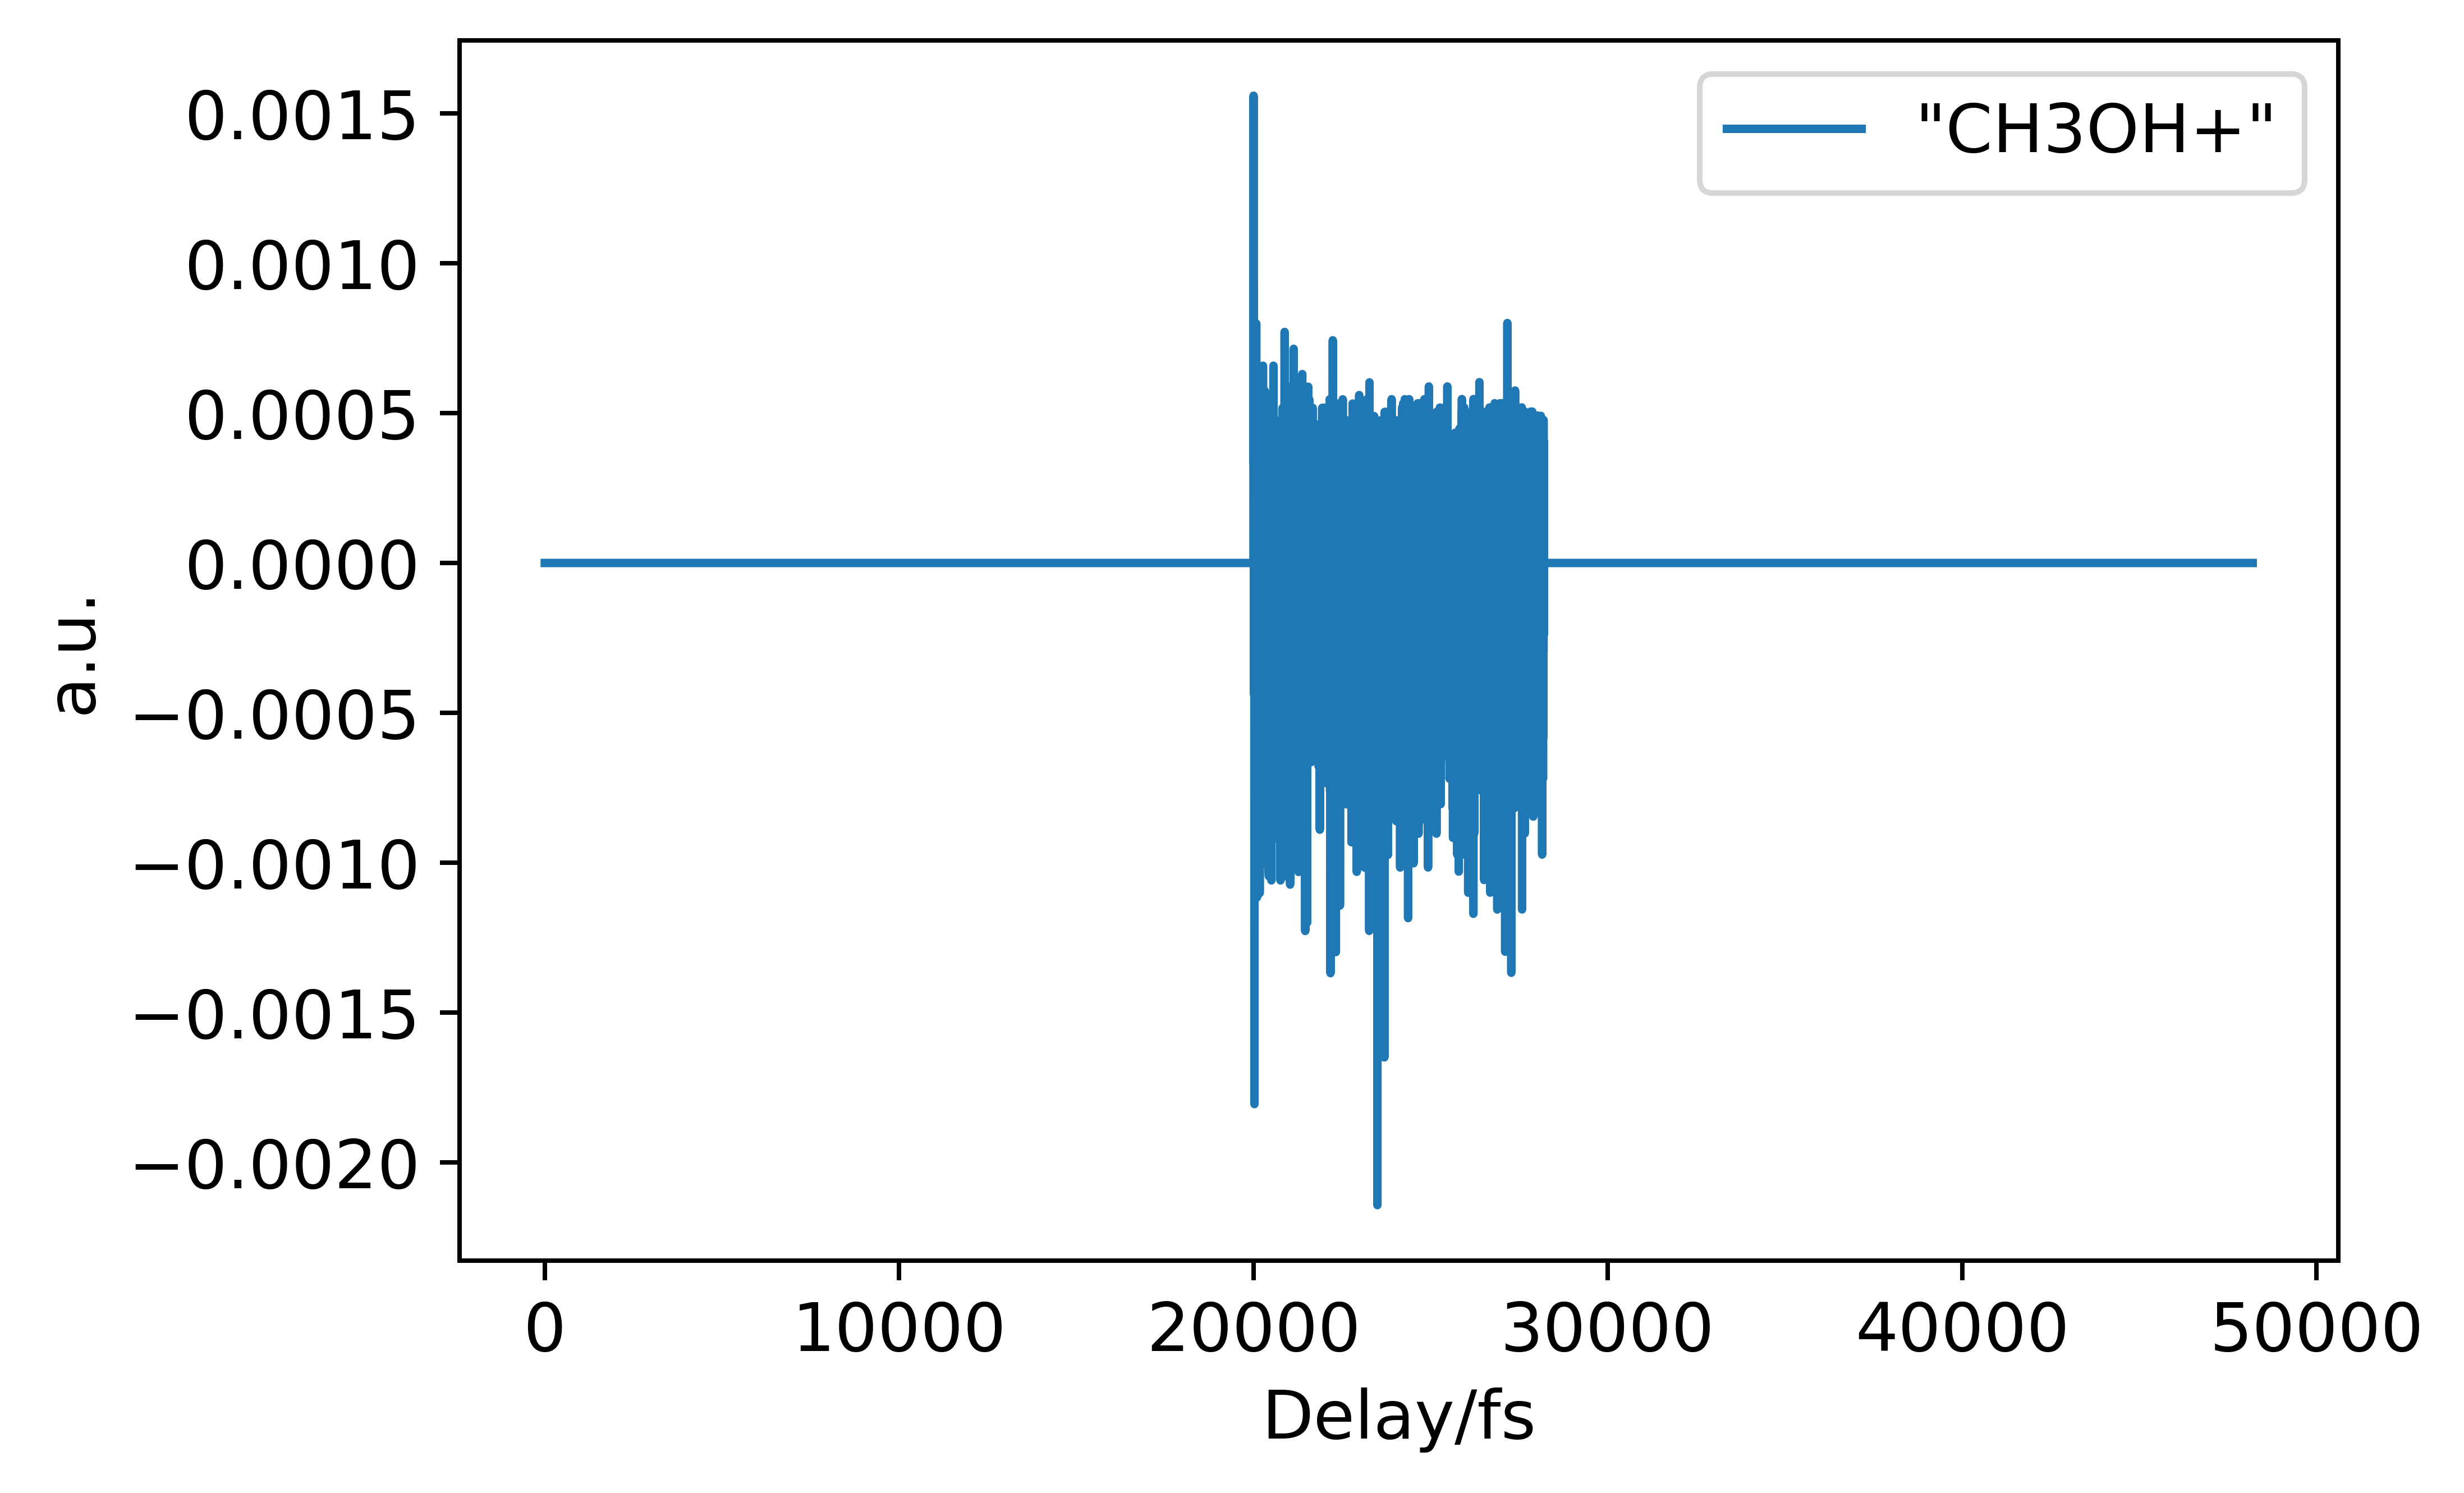

In [4]:
dataPath = pl.PureWindowsPath(r'C:\Users\TU-IEP-Schultze\Documents\Experiment\femto_ion_spectra\2021-05\2021-05-13')

gas = h5py.File(pl.PurePath(dataPath,'scan_tof_2021-05-13-16-00-55.hdf5'),'r')
data = np.array(gas['sumAll'])

delay = np.arange(len(data))*(100/10000)
f = FFTOSC(delay,data, dcRange = 2)
f.mass_spectra()
#f.runingAverage(5)
f.window(windowSize = 1800, direction = 'left', shift = 0, rmDC = False)
f.rmvExp()
f.interpS(interNum = 0)
f.padding(paddingSize =20000)
f.dataProcess()

f.show_FFT()
f.show_Spectra(0)
#f.STFTS()
#plt.show()
